In [1]:
import array
import numpy as np                                        
import pandas as pd
from sklearn.model_selection import train_test_split
#For Naive Bayes
from sklearn.naive_bayes import GaussianNB
#plotting tools
#Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
#Display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.notebook_repr_html', True)
np.set_printoptions(threshold=100)

## XGBoost Model Training

In [31]:
# Needful imports
import xgboost as xgb
import array
import numpy as np                                        
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics 

import pickle

In [4]:
#Read/load training data
# %store - r labelled_data
labelled_data1 = pd.read_csv('D:/MASS/14 inch IPIG ILI run data/IOCL_DELHI_PANIPAT_RUN_5_DEC_2015/labelled_data.csv')
labelled_data2 = pd.read_csv('D:/MASS/14 inch IPIG ILI run data/IOCL_PANIPAT_AMBALA_NI DAS_30_31_JULY_2015/labelled_data.csv')

In [173]:
labelled_data = pd.read_csv('D:/MASS/IOCL/Training Data/labelled_data.csv')

In [174]:
len(labelled_data.loc[(labelled_data['anomaly_type'].str.contains('weld')) & (labelled_data['max_span'] > 83)])

11643

In [175]:
# labelled_data1['page_idx'] = labelled_data1.apply(lambda row : (row.abs_idx) % 5000, axis=1)

In [176]:
# labelled_data1  = labelled_data1.drop(['Unnamed: 0'], axis = 1)
# labelled_data2 = labelled_data2.drop(['Unnamed: 0'], axis = 1)

In [177]:
# labelled_data1.to_csv('D:/MASS/14 inch IPIG ILI run data/IOCL_DELHI_PANIPAT_RUN_5_DEC_2015/labelled_data.csv', index=False)
# labelled_data2.to_csv('D:/MASS/14 inch IPIG ILI run data/IOCL_PANIPAT_AMBALA_NI DAS_30_31_JULY_2015/labelled_data.csv', index=False)

In [178]:
# labelled_data = pd.concat([labelled_data1, labelled_data2], ignore_index=True, sort=False)

In [179]:
# labelled_data.to_csv('D:/MASS/Training Data/labelled_data.csv', index=False)

In [180]:
#Data preparation
feature_list_to_be_used = ['min_of_moving_avg',
                           'max_of_moving_avg', 
                           'mean_of_moving_avg', 
                           'min_of_Max',
                           'max_of_Max',
                           'mean_of_Max',
                           'min_of_Min',
                           'max_of_Min',
                           'mean_of_Min',
                           'min_of_delta',
                           'max_of_delta', 
                           'mean_of_delta', 
                           'min_of_local_std',
                           'max_of_local_std',
                           'mean_of_local_std',
                           'min_of_global_std',
                           'max_of_global_std',
                           'mean_of_global_std',
                           'min_of_idx_delta',
                           'max_of_idx_delta',
                           'mean_of_idx_delta',
                           'min_of_avg', 
                           'max_of_avg',
                           'mean_of_avg',
                           'anomalous_count',
                           'max_span',
                           'anomaly_length',
                           'anomaly_type',
                           'intensity']

filtered_data = labelled_data[feature_list_to_be_used]

In [181]:
#Label cleaning like magnetic magnatic are same, area start with weld is nothing but weld etc
#This step can be reduced by cleaning labeled excel data at early stage

filtered_data.loc[filtered_data['anomaly_type'].str.contains('metal', case = False),'target_name'] = 'metal loss'
filtered_data.loc[filtered_data['anomaly_type'].str.contains('marker' , case = False),'target_name'] = 'marker'
filtered_data.loc[filtered_data['anomaly_type'].str.contains('flange', case = False),'target_name'] = 'flange'
filtered_data.loc[filtered_data['anomaly_type'].str.contains('valve', case = False),'target_name'] = 'valve'
filtered_data.loc[filtered_data['anomaly_type'].str.contains('attachment', case = False),'target_name'] = 'attachment'
filtered_data.loc[filtered_data['anomaly_type'].str.contains('tap start', case = False),'target_name'] = 'tap start'
filtered_data.loc[filtered_data['anomaly_type'].str.contains('tap end', case = False),'target_name'] = 'tap end'
filtered_data.loc[filtered_data['anomaly_type'].str.contains('sleeve start', case = False),'target_name'] = 'sleeve start'
filtered_data.loc[filtered_data['anomaly_type'].str.contains('sleeve end', case = False),'target_name'] = 'sleeve end'
filtered_data.loc[filtered_data['anomaly_type'].str.contains('weld', case = False) ,'target_name'] = 'weld'
filtered_data.loc[filtered_data['anomaly_type'].str.contains('area start', case = False) ,'target_name'] = 'area start'
filtered_data.loc[filtered_data['anomaly_type'].str.contains('area end', case = False),'target_name'] = 'area end'
filtered_data.loc[filtered_data['anomaly_type'].str.contains('unknown', case = False),'target_name'] = 'unknown'

C:\Users\admin\Anaconda2\envs\env35\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\admin\Anaconda2\envs\env35\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [182]:
#Drop all the records which is possibly marked incorrectly and contains anomaly type as 'End of CD'
filtered_data = filtered_data.drop(filtered_data[filtered_data.anomaly_type.str.contains('cd')].index)
filtered_data = filtered_data.drop(filtered_data[(filtered_data.anomalous_count < 10)].index)
filtered_data = filtered_data.drop(filtered_data[(filtered_data.target_name.str.contains('weld')) & (filtered_data.max_span <  60)].index)
# welds = filtered_data.loc[filtered_data['target_name'] == 'weld']
# weld_sample = welds.sample(n = 800)
# filtered_data = filtered_data.drop(filtered_data[(filtered_data.target_name == 'weld')].index)
# balanced_filtered_data = pd.concat([filtered_data, weld_sample], ignore_index=True)
balanced_filtered_data = filtered_data

In [194]:
# Reset the index after droping above records 
balanced_filtered_data = balanced_filtered_data.reset_index(drop =True)

In [ ]:
balanced_filtered_data['target_name'].value_counts()

weld            13930
metal loss        167
area end           92
flange             91
area start         88
marker             81
unknown            78
sleeve end         71
sleeve start       68
attachment         30
valve              19
tap start          14
tap end            12
Name: target_name, dtype: int64

In [196]:
167/len(filtered_data)

0.011328946475815753

In [197]:
#Change categorical classes to Numerical by adding a column named target value
balanced_filtered_data['target_value'] =  pd.Categorical(balanced_filtered_data.target_name).codes

In [198]:
#Preparing the final dataset to fed in machine learning model
# Following code extract 'data array' out from 'DataFrame' which is required for the model
target_value = balanced_filtered_data['target_value'].values  
target_name = balanced_filtered_data['target_name'].values
#Now we can drop these two column to seperate our featured data
data_without_label = balanced_filtered_data.drop(['target_value', 'target_name', 'anomaly_type'], axis = 1)

In [202]:
#To check the correlation among various features and drop un necessary (features which are highly correlated)
corr_matrix = data_without_label.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper = upper.transpose()
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [203]:
upper

,min_of_moving_avg,max_of_moving_avg,mean_of_moving_avg,min_of_Max,max_of_Max,mean_of_Max,min_of_Min,max_of_Min,mean_of_Min,min_of_delta,max_of_delta,mean_of_delta,min_of_local_std,max_of_local_std,mean_of_local_std,min_of_global_std,max_of_global_std,mean_of_global_std,min_of_idx_delta,max_of_idx_delta,mean_of_idx_delta,min_of_avg,max_of_avg,mean_of_avg,anomalous_count,max_span,anomaly_length,intensity
min_of_moving_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_of_moving_avg,0.430784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_of_moving_avg,0.681468,0.862233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min_of_Max,0.741511,0.062499,0.277904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_of_Max,0.351041,0.451795,0.494545,0.352693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_of_Max,0.500301,0.330668,0.507059,0.589344,0.841418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min_of_Min,0.389864,0.305893,0.380871,0.226967,0.016930,0.085603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_of_Min,0.040868,0.537891,0.369806,0.176256,0.043342,0.069034,0.468418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_of_Min,0.061349,0.371855,0.290112,0.079320,0.001680,0.048082,0.744242,0.771466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min_of_delta,0.456891,0.117649,0.105241,0.706321,0.346407,0.562693,0.236871,0.582477,0.547227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
data_without_label = data_without_label.drop(to_drop, axis = 1)
print('Dropped highly correlated features list ', to_drop)

Dropped highly correlated features list  ['mean_of_delta']


In [119]:
data_array = data_without_label.values
#Lets put all these data arrays in a single Dictionary so that I would be easy to carry all the data for model fitting/training
final_anomaly_dataset = {}
final_anomaly_dataset['data'] = data_array
final_anomaly_dataset['target_value'] = target_value
final_anomaly_dataset['target_name'] = target_name

In [40]:
#Dump this dataset for further use
with open('D:/MASS/IOCL/Training Data/classified_anomaly_dataset.pkl', 'wb') as f:
    pickle.dump([final_anomaly_dataset], f)

In [41]:
#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(final_anomaly_dataset['data'], final_anomaly_dataset['target_value'], test_size=0.20)

In [142]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(data_without_label)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [143]:
labels = kmeans.predict(data_without_label)
centroids = kmeans.cluster_centers_

In [146]:
data_without_label['max_of_moving_avg']

0        0.881078
1        0.855388
2        0.866265
3        0.867254
4        0.873042
5        0.848532
6        0.872709
7        0.911540
8        0.862316
9        0.825136
10       0.837741
11       0.864506
12       0.854792
13       0.886451
14       0.854477
15       0.852986
16       0.851282
17       0.823199
18       0.803682
19       0.797591
20       0.780444
21       0.779086
22       0.777367
23       0.779268
24       0.783635
25       0.821995
26       0.639049
27       0.626511
28       0.632546
29       0.651994
30       0.591723
31       0.691599
32       0.678028
33       0.591224
34       0.654601
35       0.593249
36       0.557987
37       0.637789
38       0.650171
39       0.623575
40       0.650407
41       0.698846
42       0.625767
43       0.658875
44       0.658410
45       0.641186
46       0.623087
47       0.628075
48       0.648149
49       0.699753
50       0.715304
51       0.644320
52       0.695859
53       0.620106
54       0.586242
55       0

In [ ]:
fig = plt.figure(figsize=(5, 5))

colors = map(lambda x: colmap[x+1], labels)

plt.scatter(data_without_label['max_of_moving_avg'], data_without_label['mean_of_moving_avg'], color=colors, alpha=0.5, edgecolor='k')
for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, color=colmap[idx+1])
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.show()

In [42]:
#Set the parameter for the model XGBoost
param = {
    'max_depth': 6,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 13}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

In [43]:
# Lest convert the train/test data into xgboost's Dmatrix(as model's requirement)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [44]:
#Finally we are ready to train our model xgboost
XGBoost = xgb.train(param, dtrain, num_round)

In [45]:
#Here we go for test
predics = XGBoost.predict(dtest)

In [46]:
#What's the performance of the model ? lets find out
best_preds = np.asarray([np.argmax(line) for line in predics])

In [48]:
#Lets find out the precision
xgb_precision = precision_score(y_test, best_preds, average='weighted')
print('xgb_precision = ', xgb_precision)

#F1-score
xgb_f1_score = metrics.f1_score(y_test, best_preds, average='weighted', labels=np.unique(best_preds))
print('xgb_f1_score = ', xgb_f1_score)

#Accuracy
accu_score = metrics.accuracy_score(y_test, best_preds)
print('accu_score = ', accu_score)

#Errors
rmse = np.sqrt(mean_squared_error(y_test, best_preds))
print("RMSE: %f" % (rmse))

xgb_precision =  0.9748453028602798
xgb_f1_score =  0.9777061615122614
accu_score =  0.9776195320447609
RMSE: 1.021970


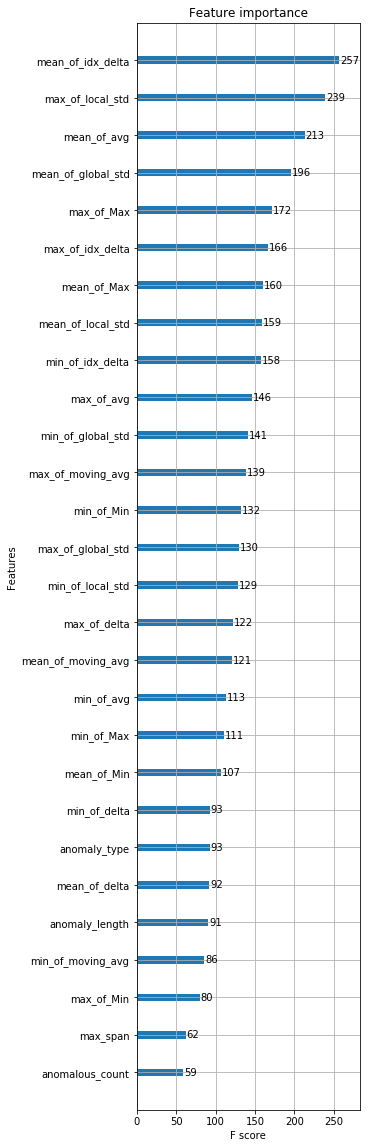

In [1437]:
XGBoost.get_fscore()
mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_list_to_be_used)}
mapped = {mapper[k]: v for k, v in XGBoost.get_fscore().items()}
mapped
xgb.plot_importance(mapped)
plt.rcParams['figure.figsize'] = [4, 20]
plt.show()

In [1438]:
trans_data = data_without_label.transpose()
print(trans_data.index[13])

max_of_local_std


In [1439]:
XGBoost.best_iteration

19

In [1440]:
grph

<bound method Booster.attributes of <xgboost.core.Booster object at 0x0000027166D73B38>>

In [1445]:
#Its time to pack up!!! 
#Finally dump the model if it performs well
#Dump this dataset for further use
with open('D:/MASS/XGBoost.pkl', 'wb') as f:
    pickle.dump(XGBoost, f)

In [1446]:
with open("D:/MASS/XGBoost.pkl", "rb") as f:
    XGBoost = pickle.load(f)

# Gaussian NB Model

In [1447]:
from sklearn import metrics
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("Gaussian model's Accuracy:", metrics.accuracy_score(y_test, y_pred))

Gaussian model's Accuracy: 0.5541795665634675
